# Plot some metrics

In [1]:
import json

with open('metrics_lr3e-5.txt') as f:  # I renamed the file
  metrics = [json.loads(line) for line in f]

all_keys = sorted(set([k for m in metrics for k in m]))
print(f"All available keys:\n - {'\n - '.join(all_keys)}")

All available keys:
 - avg_sup_seqlen
 - core_hours
 - core_hours_NVIDIA A40
 - epoch
 - eval/acc/acc
 - eval/acc/acc_any
 - eval/acc/anls
 - eval/acc/num
 - examples_seen
 - global_schedule
 - global_schedule1
 - img/sec/core
 - l2_grads
 - l2_params
 - l2_updates
 - max_sup_seqlen
 - progress
 - step
 - training_loss
 - uptime
 - val/pplx/avg
 - val/pplx/sum
 - z/secs/eval/eval/acc
 - z/secs/eval/val/pplx
 - z/secs/update0


In [2]:
import numpy as np

def xy(ms, x, y, ymul=1):
  xs = np.array([m[x] for m in ms if x in m and y in m])
  ys = np.array([m[y] for m in ms if x in m and y in m]) * ymul
  return xs, ys

with np.printoptions(precision=3, suppress=True):
  x, y = xy(metrics, 'step', 'eval/acc/acc')
  print(x, '\n', y)
  x, y = xy(metrics, 'epoch', 'training_loss')
  print(x, '\n', y)

[ 5 10 15 20 25 30 35 40 40] 
 [0.376 0.719 0.897 0.785 0.932 0.944 0.942 0.943 0.943]
[ 0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.
  3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75  6.
  6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75  9.
  9.25  9.5   9.75 10.   10.  ] 
 [5.726 5.484 1.439 0.704 0.849 0.483 0.602 0.53  0.502 0.404 0.416 0.236
 0.714 0.511 0.274 0.247 0.169 0.287 0.048 0.047 0.074 0.103 0.297 0.003
 0.002 0.001 0.    0.002 0.001 0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.   ]


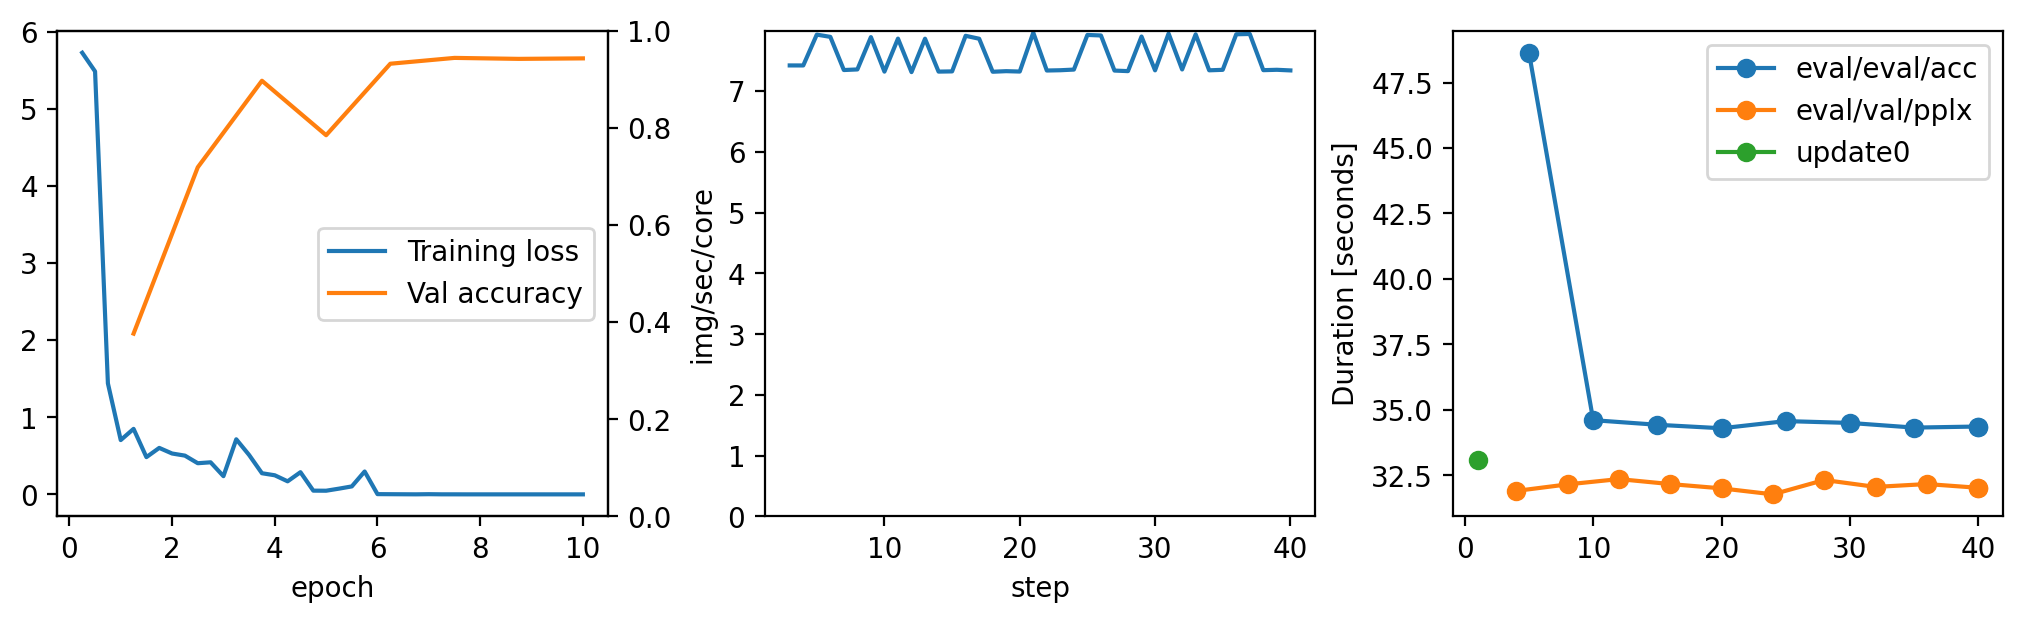

In [36]:
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl

fig, axes = mpl.pyplot.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
l1, = axes[0].plot(*xy(metrics, 'epoch', 'training_loss'), label='Training loss')
axes[0].set_xlabel('epoch')  # We should do log-y, but this is prettier :)
ax0twin = axes[0].twinx()
l2, = ax0twin.plot(*xy(metrics, 'epoch', 'eval/acc/acc'), c='C1', label='Val accuracy')
ax0twin.set_ylim(0, 1)
ax0twin.legend([l1, l2], [l1.get_label(), l2.get_label()], loc='center right')

axes[1].plot(*xy(metrics, 'step', 'img/sec/core'))
axes[1].set_ylim(0, None)
axes[1].set_ylabel('img/sec/core')
axes[1].set_xlabel('step')

for k in filter(lambda k: k.startswith('z/secs'), all_keys):
    axes[2].plot(*xy(metrics, 'step', k), 'o-', label=k.replace('z/secs/', ''))
axes[2].legend()
axes[2].set_ylabel('Duration [seconds]')
fig.savefig('plot.svg')

# Look at (mis-)predictions

In [10]:
import json
import random

In [2]:
with open("vqa_eval_0.json") as f:
  preds = json.load(f)
preds[0]

{'question_id': '0', 'answer': '1', 'gts': ['1']}

In [4]:
wrongs = [p for p in preds if p['answer'] not in p['gts']]
len(wrongs)

57

In [9]:
qid2img = [json.loads(line)["image"] for line in open('lines_data/val.jsonl')]

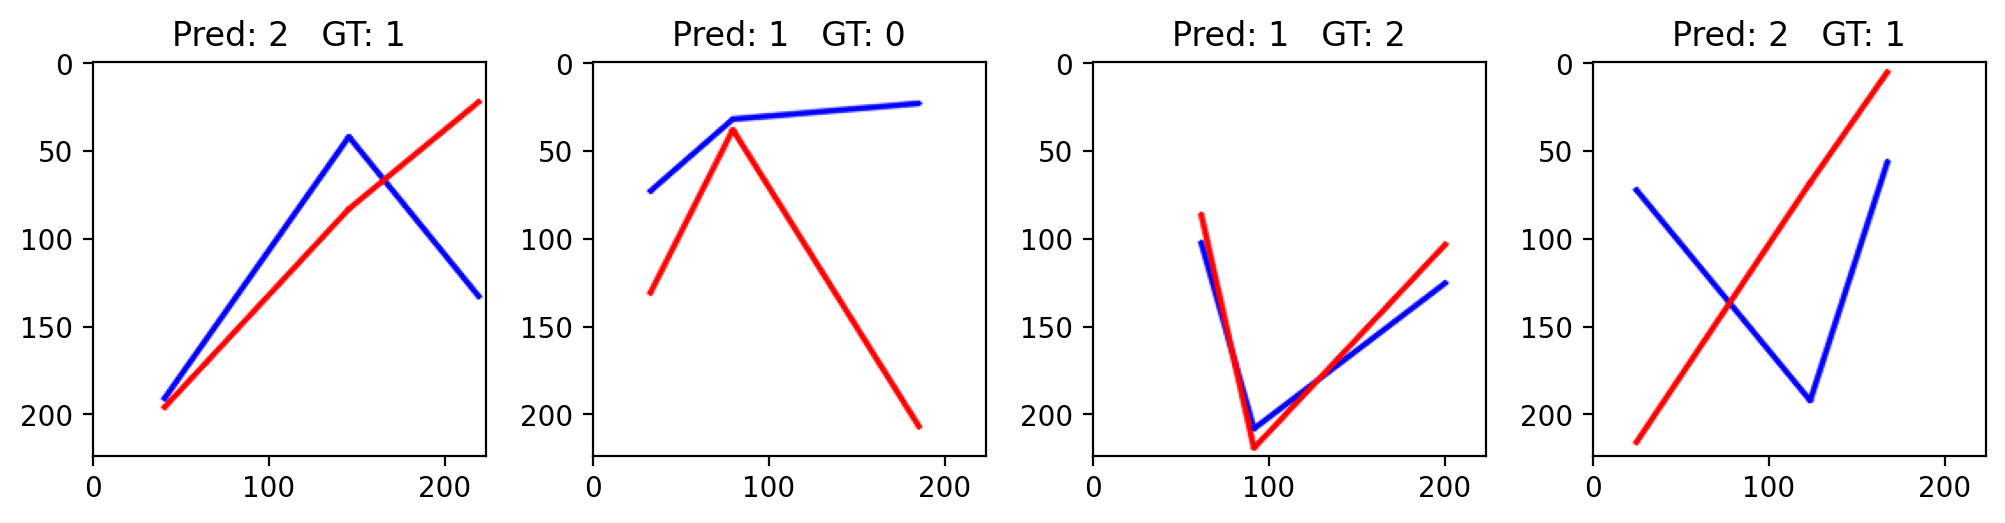

In [18]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(10, 2.5), constrained_layout=True)
for ax, w in zip(axes.flat, random.choices(wrongs, k=4)):
  ax.imshow(plt.imread('lines_data/' + qid2img[int(w['question_id'])]))
  ax.set_title(f'Pred: {w["answer"]}   GT: {w["gts"][0]}')
fig.savefig('errors.svg')

# Maybe prettier plots in the future here.

In [8]:
exs = [8, 32, 128, 512, 1024]
lrs = ["3e-4", "1e-4", "3e-5", "1e-5", "3e-6", "1e-6"]
eps = [3, 10, 30, 100, 300]

In [9]:
def read_metrics(ex, lr, ep):
  with open(f"workdirs/workdir_ex{ex}_lr{lr}_ep{ep}_11-20_2338/big_vision_metrics.txt") as f:
    return [json.loads(line) for line in f]

def get_final(y):
  vals = xr.DataArray(np.full((len(exs), len(lrs), len(eps)), np.nan), dims=("ex", "lr", "ep"), coords={"ex": exs, "lr": lrs, "ep": eps})

  for i_ex in exs:
    for i_ep in eps:
      for i_lr in lrs:
        x_, y_ = xy(read_metrics(ex=i_ex, lr=i_lr, ep=i_ep), x='step', y=y)
        vals.loc[dict(ex=i_ex, ep=i_ep, lr=i_lr)] = y_[-1]

  return vals

ms = read_metrics(ex=128, lr="1e-5", ep=300)
finals = get_final("eval/acc/acc")

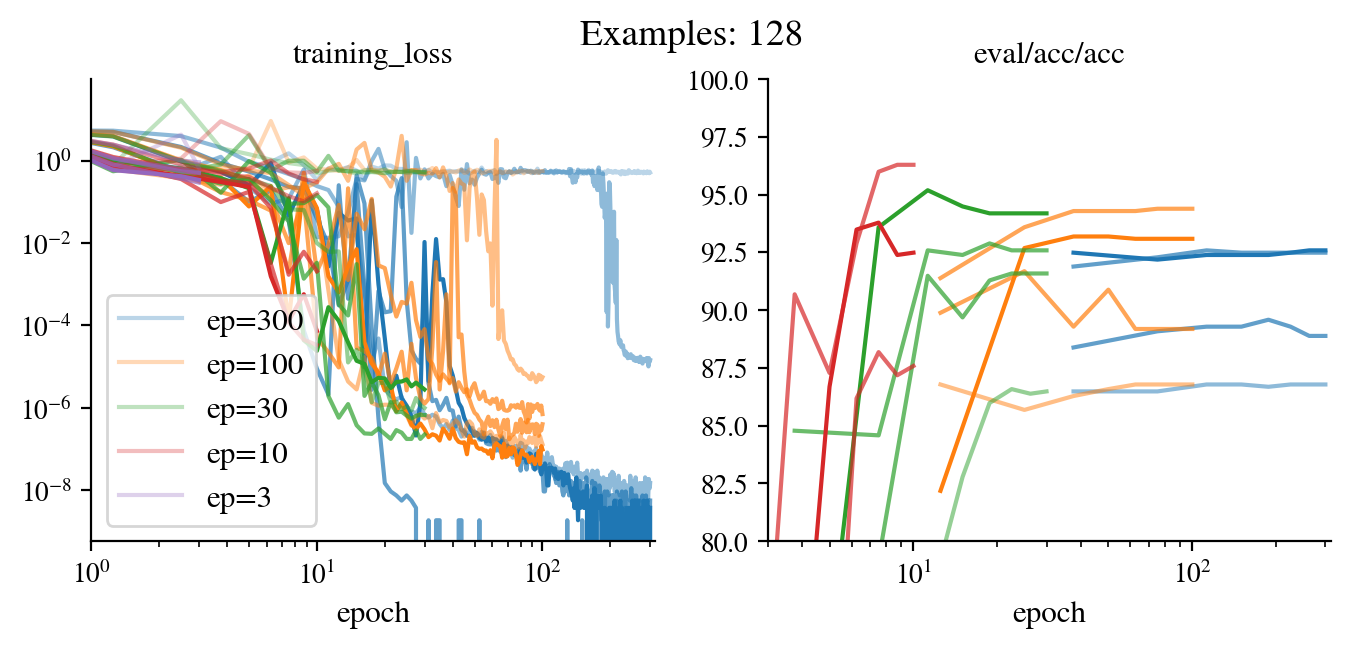

In [10]:
X = 'epoch'
Y1 = 'training_loss'
Y2 = 'eval/acc/acc'

with mpl.rc_context({'axes.spines.right': False, 'axes.spines.top': False, **latex_context(0.7)}):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
  for c, ep in zip(['C0', 'C1', 'C2', 'C3', 'C4'], reversed(eps)):
    # for lw, lr in zip([0.5, 1.0, 1.5, 3.0, 1.5, 0.5], lrs):
    for a, lr in zip([0.3, 0.5, 0.7, 1.0, 0.7, 0.5], lrs):
      ax1.plot(*xy(read_metrics(ex=128, lr=lr, ep=ep), x=X, y=Y1), c=c, alpha=a, lw=1.5, label=f'ep={ep}' if lr == lrs[0] else None)
      ax2.plot(*xy(read_metrics(ex=128, lr=lr, ep=ep), x=X, y=Y2, ymul=100), c=c, alpha=a, lw=1.5, label=f'ep={ep}' if lr == lrs[0] else None)
  ax1.legend()
  ax1.set_yscale('log') ; ax2.set_ylim(80, 100)
  ax1.set_xlim(1, None) ; ax2.set_xlim(3, None)
  ax1.set_xscale('log') ; ax2.set_xscale('log')
  ax1.set_xlabel(X) ; ax2.set_xlabel(X)
  ax1.set_title(Y1) ; ax2.set_title(Y2)
  fig.suptitle('Examples: 128');

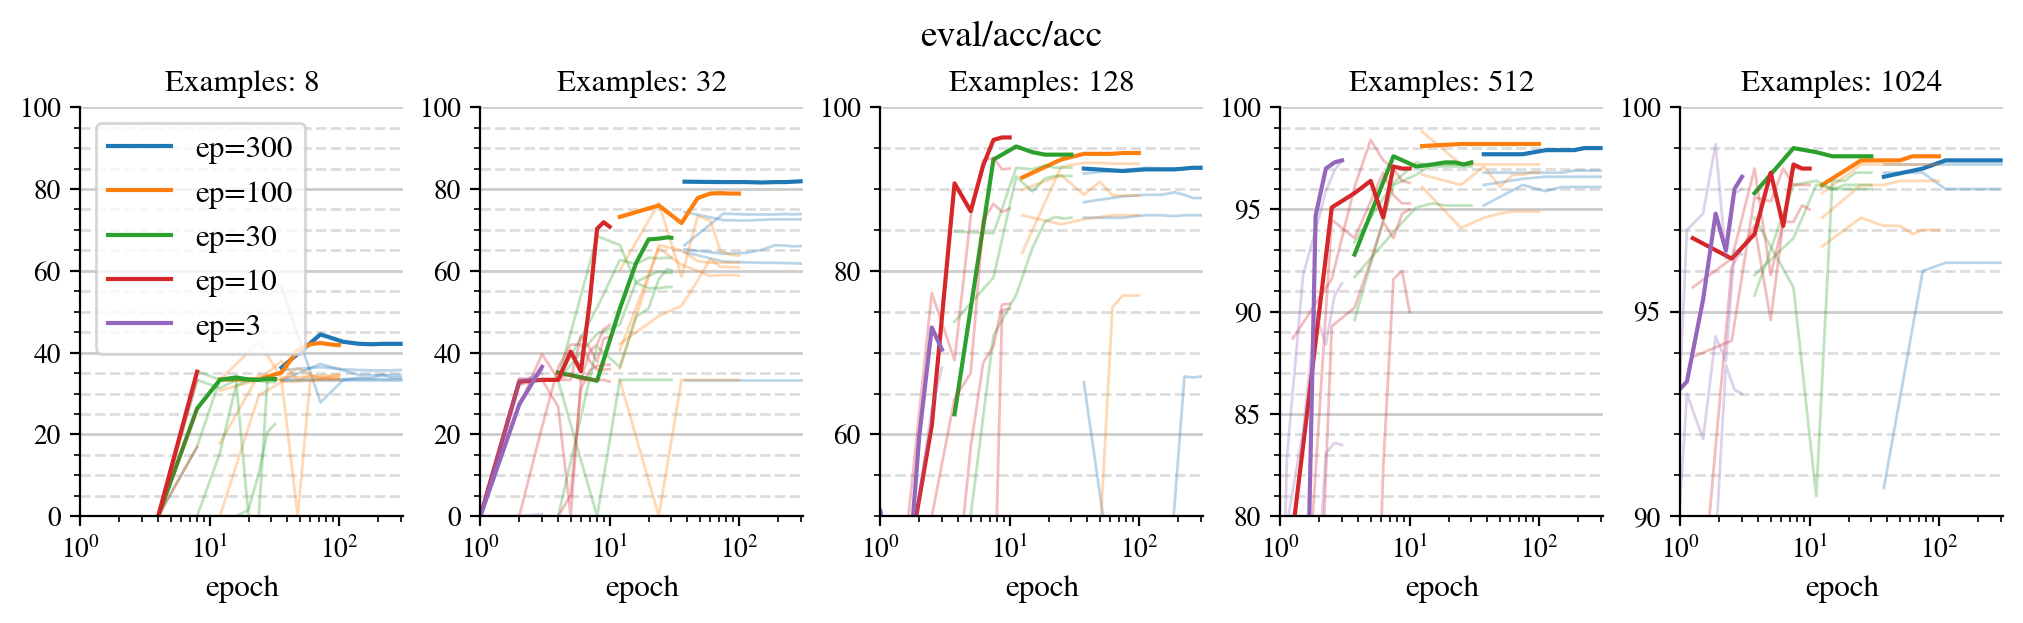

In [11]:
X = 'epoch'
Y = 'eval/acc/acc'

with mpl.rc_context({'axes.spines.right': False, 'axes.spines.top': False, **latex_context(0.7)}):
  fig, axes = plt.subplots(1, len(exs), figsize=(2*len(exs), 3), sharey=False, constrained_layout=True)
  for ax, ex in zip(axes, exs):
    ax.set_title(f'Examples: {ex}')
    for c, ep in zip(['C0', 'C1', 'C2', 'C3', 'C4'], reversed(eps)):
      best_lr = finals.sel(ex=ex, ep=ep).idxmax('lr').item()
      for lr in lrs:
        try:
          kw = dict(alpha=1.0, lw=1.5) if lr == best_lr else dict(alpha=0.3, lw=1)
          ax.plot(*xy(read_metrics(ex=ex, lr=lr, ep=ep), x=X, y=Y, ymul=100), c=c, **kw,
                  label=f'ep={ep}' if lr == best_lr else None)
        except FileNotFoundError:
          pass
    # ax.legend(loc='lower center')
  
  axes[0].legend(ncol=1)
  for ax in axes:
    ax.set_ylim(0, 100)
    ax.set_xlim(1, None)
    ax.set_xscale('log')
    ax.set_xlabel(X)
  make_hgrid(axes[0], ylim=(0, 100), major=range(0, 101, 20), minor=range(0, 101, 5))
  make_hgrid(axes[1], ylim=(0, 100), major=range(0, 101, 20), minor=range(0, 101, 5))
  make_hgrid(axes[2], ylim=(50, 100), major=range(0, 101, 20), minor=range(0, 101, 5))
  make_hgrid(axes[3], ylim=(80, 100), major=range(0, 101, 5), minor=range(0, 101, 1))
  make_hgrid(axes[4], ylim=(90, 100), major=range(0, 101, 5), minor=range(0, 101, 1))
  fig.suptitle(Y);

In [15]:
finals.sel(ex=128, ep=10)

<xarray.DataArray (lr: 6)> Size: 48B
array([0.33333333, 0.75375375, 0.96296296, 0.92492492, 0.87587588,
       0.75975976])
Coordinates:
    ex       int64 8B 128
  * lr       (lr) <U4 96B '3e-4' '1e-4' '3e-5' '1e-5' '3e-6' '1e-6'
    ep       int64 8B 10

In [36]:
lr = finals.sel(ex=1024, ep=30).idxmax('lr').item()
preds = json.load(open(f'workdirs/workdir_ex{1024}_lr{lr}_ep{30}_11-20_2338/vqa_eval_0.json'))

In [3]:
exs = [8, 32]
bss = [2, 4, 8, 16, 32]
lrs = ["3e-4", "1e-4", "3e-5", "1e-5", "3e-6", "1e-6"]
lss = ["0.0"]
dos = ["0.0", "0.1", "0.2"]
eps = [3, 10, 30, 100, 300]

In [61]:
def read_metrics(ex, bs, lr, ls, do, ep):
  return read_jsonl(f"workdirs/workdir_sweep2_ex{ex}_bs{bs}_lr{lr}_ls{ls}_do{do}_ep{ep}_11-22_1052/big_vision_metrics.txt")

In [62]:
def get_final(y):
  nans = np.full((len(exs), len(bss), len(lrs), len(lss), len(dos), len(eps)), np.nan)
  vals = xr.DataArray(nans, dims=("ex", "bs", "lr", "ls", "do", "ep"), coords={"ex": exs, "bs": bss, "lr": lrs, "ls": lss, "do": dos, "ep": eps})

  kw = {}
  for kw["ex"] in exs:
    for kw["bs"] in bss:
      for kw["lr"] in lrs:
        for kw["ls"] in lss:
          for kw["do"] in dos:
            for kw["ep"] in eps:
              print(f"\rReading: {kw}", end="", flush=True)
              x_, y_ = xy(read_metrics(**kw), x='step', y=y)
              vals.loc[kw] = y_[-1]
  return vals

ms = read_metrics(ex=8, bs=8, lr="1e-5", ls="0.0", do="0.2", ep=300)
finals = get_final("eval/acc/acc")

Reading: {'ex': 32, 'bs': 2, 'lr': '1e-6', 'ls': '0.0', 'do': '0.0', 'ep': 300}WARNING: Some steps might be missing because there was corruption on line 1199 of file workdirs/workdir_sweep2_ex32_bs2_lr1e-6_ls0.0_do0.0_ep300_11-22_1052/big_vision_metrics.txt
Reading: {'ex': 32, 'bs': 2, 'lr': '1e-6', 'ls': '0.0', 'do': '0.1', 'ep': 300}WARNING: Some steps might be missing because there was corruption on line 2601 of file workdirs/workdir_sweep2_ex32_bs2_lr1e-6_ls0.0_do0.1_ep300_11-22_1052/big_vision_metrics.txt
Reading: {'ex': 32, 'bs': 2, 'lr': '1e-6', 'ls': '0.0', 'do': '0.2', 'ep': 300}WARNING: Some steps might be missing because there was corruption on line 3422 of file workdirs/workdir_sweep2_ex32_bs2_lr1e-6_ls0.0_do0.2_ep300_11-22_1052/big_vision_metrics.txt
Reading: {'ex': 32, 'bs': 4, 'lr': '1e-6', 'ls': '0.0', 'do': '0.1', 'ep': 30}}WARNING: Some steps might be missing because there was corruption on line 209 of file workdirs/workdir_sweep2_ex32_bs4_lr1e-6_ls0.0_do0.1_ep30_11-2

In [79]:
def idxmax(x):
  return {k: x.indexes[k][v.item()] for k, v in x.argmax(...).items()}

idxmax(finals.sel(ex=8, ep=300))

{'bs': np.int64(4), 'lr': '1e-5', 'ls': '0.0', 'do': '0.0'}

In [117]:
import itertools

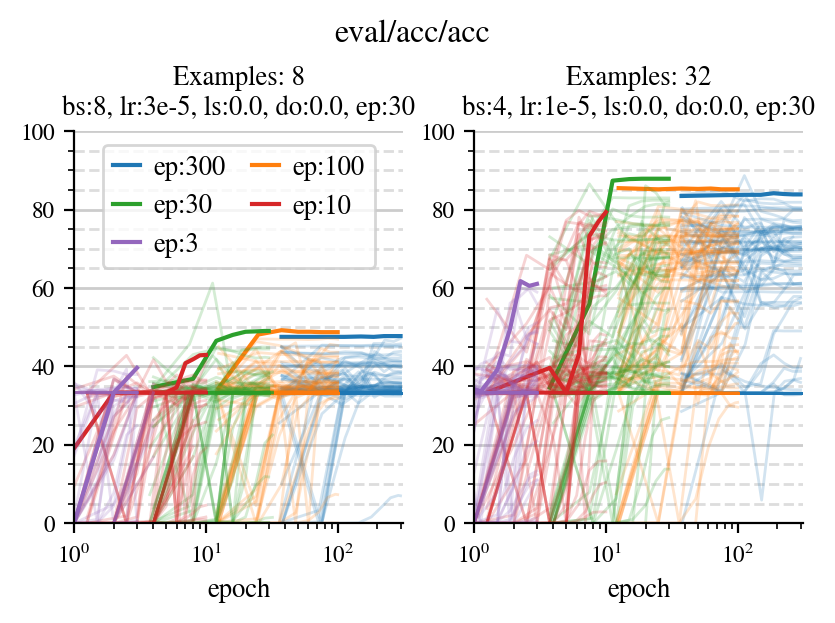

In [118]:
X = 'epoch'
Y = 'eval/acc/acc'

with mpl.rc_context({'axes.spines.right': False, 'axes.spines.top': False, **latex_context(0.6)}):
  fig, axes = plt.subplots(1, len(exs), figsize=(2*len(exs), 3), sharey=False, constrained_layout=True)
  for ax, ex in zip(axes, exs):
    ex_best = idxmax(finals.sel(ex=ex))
    ax.set_title(f'Examples: {ex}\n' + ', '.join(f"{k}:{v}" for k, v in ex_best.items()))
    for c, ep in zip(['C0', 'C1', 'C2', 'C3', 'C4'], reversed(eps)):
      best = idxmax(finals.sel(ex=ex, ep=ep))
      for bs, lr, ls, do in itertools.product(bss, lrs, lss, dos):
        kw = dict(bs=bs, lr=lr, ls=ls, do=do)
        try:
          is_best = all(kw[k] == best[k] for k in best)
          line_kw = dict(alpha=1.0, lw=1.5) if is_best else dict(alpha=0.2, lw=1)
          ax.plot(*xy(read_metrics(ex=ex, ep=ep, **kw), x=X, y=Y, ymul=100), c=c, **line_kw, label=f'ep:{ep}' if is_best else None)
        except FileNotFoundError:
          pass
  
  def flip(items, ncol=2):
      return itertools.chain(*[items[i::ncol] for i in range(ncol)])
  handles, labels = axes[0].get_legend_handles_labels()
  axes[0].legend(flip(handles), flip(labels), loc='upper center', ncol=2, handlelength=1, handletextpad=0.5, columnspacing=1)

  for ax in axes:
    make_hgrid(ax, ylim=(0, 100), major=range(0, 101, 20), minor=range(0, 101, 5))
    ax.set_xlim(1, None)
    ax.set_xscale('log')
    ax.set_xlabel(X)
  fig.suptitle(Y);